# Measure distance along a center line
A common question is how to determine distances of points along the centerline of an object. For this we can skeletonize the object, determine distances along the center line and then find the closest center line pixel to given point coordinates. 

See also:
* https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html

In [1]:
import bia_bob

In [2]:
from skimage.io import imread
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_simpleitk_image_processing as nsitk
import numpy as np
import skan
import stackview
import pyclesperanto_prototype as cle
from scipy.spatial.distance import euclidean

## Starting point: a binary image
We start using a binary image that looks like an arm.

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
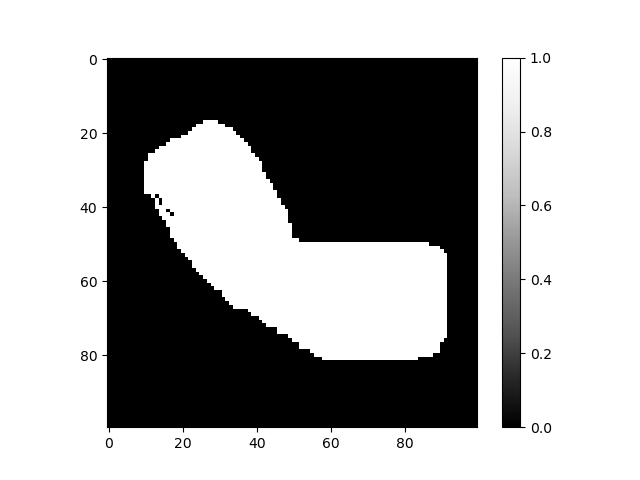
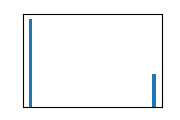

In [3]:
binary_arm = imread("../../data/binary_arm.tif")
stackview.insight(binary_arm)

Furthermore, we continue with a list of coordinates in X/Y format:

In [4]:
coordinates_xy = np.asarray([
                  [80, 70],
                  [70, 70],
                  [60, 70],
                  [40, 40]]).T

We next produce a label image where the given coordinates are labeled. The first coordinate (index=0 in the list) will be labeled with 1, the second with 2, and so on. Background pixels are 0. 
We use this label image for visualization and further down, we will also use this image to do the measurement.

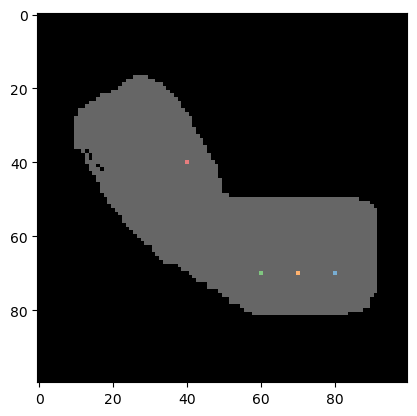

In [5]:
# draw the coordinates into an image; for visualization purposes
blank_image = cle.create((binary_arm.shape))
labeled_spots = coordinate_visualization = cle.pointlist_to_labelled_spots(coordinates_xy, blank_image)

# show the labeled pixels on top of the binary image
cle.imshow(binary_arm, continue_drawing=True, max_display_intensity=1)
cle.imshow(labeled_spots, labels=True, alpha=0.6)

## Pre-processing
Before we can skeletonize the image, we need to fill the black holes in the white area.

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
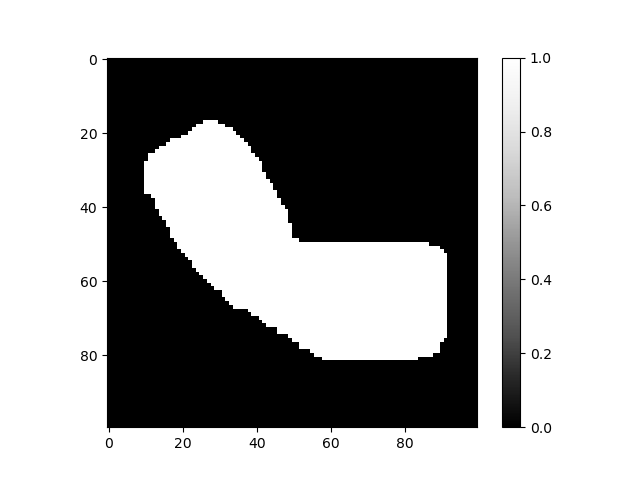
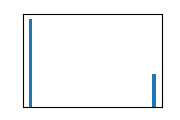

In [6]:
filled_holes = nsitk.binary_fill_holes(binary_arm)
filled_holes

## Skeletonization
The [skeleton of a binary image](https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html) is a thin line in the center of white areas.

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
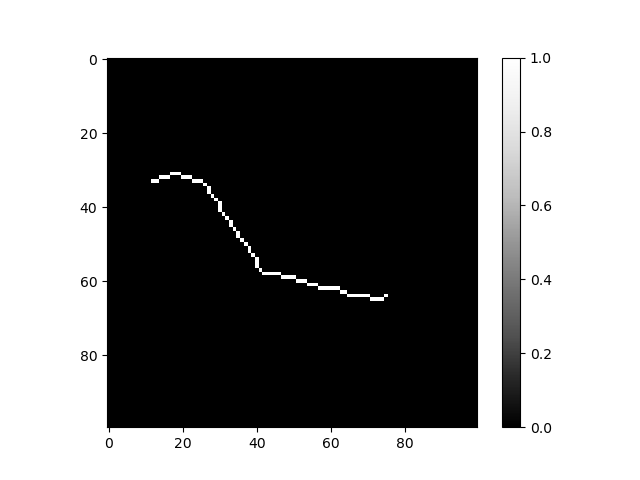
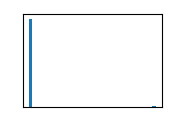

In [7]:
skeleton = nsbatwm.skeletonize(filled_holes)
skeleton

## Distance along the skeleton
We first scan the skeleton and retrieve a list of coordinates.

In [8]:
def skeleton_to_pointlist(skeleton):
    # Convert binary image into a graph representation
    graph = skan.Skeleton(skeleton)
    
    # Extract the coordinates of the polyline from the graph
    polyline = graph.path_coordinates(0)

    return polyline

polyline = skeleton_to_pointlist(skeleton)
polyline[:5]

array([[33, 12],
       [33, 13],
       [32, 14],
       [32, 15],
       [32, 16]], dtype=int64)

We then compute the distance of all pixels within the skeleton to one end of the skeleton. We have little influence to which end the measurement is done.

In [9]:
def distances_along_pointlist(polyline):
    # Initialize a list to store the distances
    distances = [0]
    
    # Compute the distance between each pair of consecutive points in the polyline
    # Iterate over pairs of points using zip and calculate the Euclidean distance 
    # between 'point' and 'follower' for each pair
    # Append the distance to the list 'distances'
    for point, follower in zip(polyline[:-1], polyline[1:]):
        d = euclidean(point, follower)
        distances.append(np.sum(distances[-1]) + d)

    return distances

distances = distances_along_pointlist(polyline)
distances[:5]

[0, 1.0, 2.414213562373095, 3.414213562373095, 4.414213562373095]

We can also visualize the distance along the skeleton as sanity check.

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
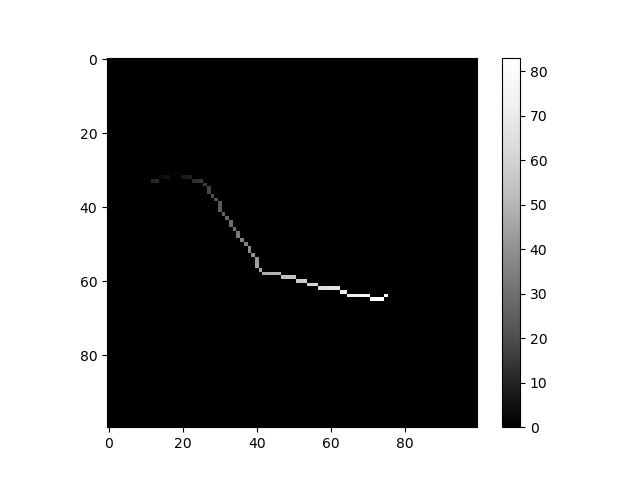
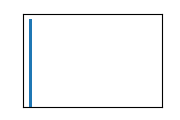

In [10]:
cle.replace_intensities(cle.label_spots(skeleton), [0] + distances)

## Distance matrix
For computing a distance matrix from each point coordinate to each pixel on the skeleton, we need to reformat our data.

In [11]:
# format the [[Y1,X1], [Y2,X2], ...] list into
# [[X1, X2, ...], [Y1, Y2, ...]] clesperanto format
polyline_xy = polyline[:,::-1].T
polyline_xy

array([[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        27, 28, 29, 30, 30, 30, 31, 32, 33, 33, 34, 35, 35, 36, 37, 38,
        38, 39, 40, 40, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75],
       [33, 33, 32, 32, 32, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 58, 58, 58, 58, 59, 59, 59, 59, 60,
        60, 60, 61, 61, 61, 62, 62, 62, 62, 62, 62, 63, 63, 64, 64, 64,
        64, 64, 64, 65, 65, 65, 65, 64]], dtype=int64)

A distance matrix gives a 2D represenation of all points in a given list to all points given in another list of points.

In [12]:
distance_matrix = cle.generate_distance_matrix(coordinates_xy, polyline_xy)[1:,1:]
print(distance_matrix[:7])

[[77.41447  68.7968   60.60528  28.861738]
 [76.537575 67.955864 59.816383 27.89265 ]
 [76.15773  67.6757   59.665733 27.20294 ]
 [75.29276  66.85058  58.898216 26.24881 ]
 [74.431175 66.0303   58.137768 25.298222]
 [74.094536 65.802734 58.0517   24.698177]
 [73.246155 65.       57.31492  23.769728]]


In [13]:
distance_matrix.shape

(72, 4)

The closest point along the skeleton to each of our four points can be determined using argmin projection in the distance matrix.

In [14]:
indices_on_skeleton = np.asarray(cle.arg_minimum_y_projection(distance_matrix))[0]
indices_on_skeleton

array([70., 67., 59., 24.], dtype=float32)

From these indices, we can read out the distance along the skeleton.

In [15]:
distances_along_skeleton = [distances[int(i)] for i in indices_on_skeleton]
distances_along_skeleton

[81.59797974644663, 78.59797974644663, 69.76955262170044, 28.970562748477146]

## A helper function to do it all
We now formulate a function that takes the skeleton and the list of coordinates to all the things shown above.

In [16]:
def distances_of_points_along_skeleton(skeleton, coordinates_xy):
    """
    Takes a binary skeleton image and a list of coordinates in format [[X1, X2, ...], [Y1, Y2, ...]]
    It will then determine all distances of the points along the skeleton. 
    """
    polyline = skeleton_to_pointlist(skeleton)
    distances = distances_along_pointlist(polyline)
    
    polyline_xy = polyline[:,::-1].T
    distance_matrix = cle.generate_distance_matrix(coordinates_xy, polyline_xy)[1:,1:]

    indices_on_skeleton = np.asarray(cle.arg_minimum_y_projection(distance_matrix))[0]
    distances_along_skeleton = [distances[int(i)] for i in indices_on_skeleton]

    return distances_along_skeleton

distances_of_points_along_skeleton(skeleton, coordinates_xy)

[81.59797974644663, 78.59797974644663, 69.76955262170044, 28.970562748477146]

## A distance map of the binary image
To check that our distance computation makes sense, also visually, we can compute the distance along the center line (skeleton) for all pixels in the binary image.
Therefore we first label all pixels individually.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
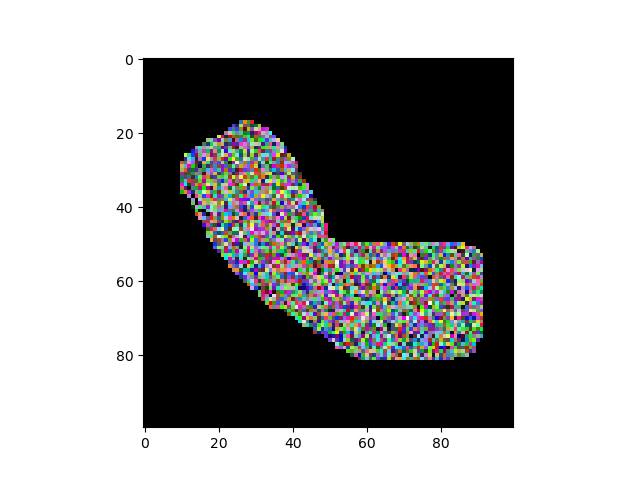

In [17]:
all_pixels_labeled = cle.label_spots(binary_arm)
all_pixels_labeled

We then compute the distance along the skeleton for all labeled pixel like above and visualize this in an image.

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
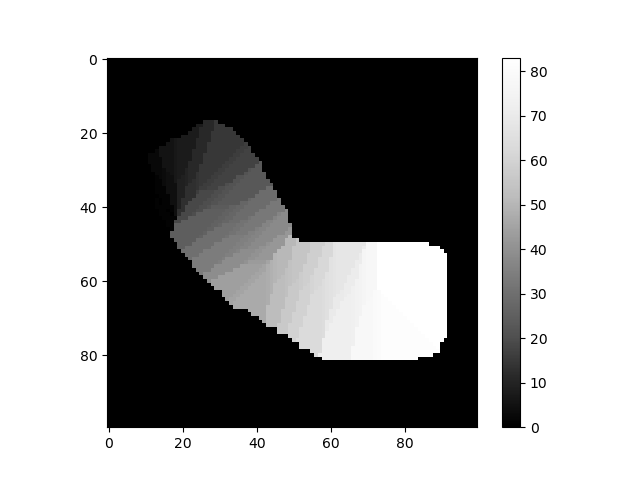
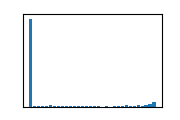

In [18]:
coordinates_all_xy = cle.labelled_spots_to_pointlist(all_pixels_labeled)
distances_all = distances_of_points_along_skeleton(skeleton, coordinates_all_xy)
distance_map = cle.replace_intensities(all_pixels_labeled, [0] + distances_all)
distance_map

Using [`stackview.picker`](https://github.com/haesleinhuepf/stackview#pick-intensities) we can hover with the mouse over the image and read out intensities. This only works in a Jupyter-like environment.

In [19]:
stackview.picker(distance_map, zoom_factor=4)

## Exercise
Compute the distance of the points with respect to the other end of the image. Hint: Flip the input image when computing the path along the skeleton.